# Colaboraciones entre más de 50 artistas 

In [585]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.metrics import precision_score, recall_score
from concurrent.futures import ThreadPoolExecutor

In [586]:
# Configura tus credenciales de la API de Spotify
client_id = 'ea3f14cac2274f8aa7a071614d8f29af'
client_secret = '61ee483d5d5f472daf9cd19938532935'
redirect_uri = 'http://localhost:8888/callback'

In [587]:
# Autenticación en la API de Spotify
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri,scope="user-library-read user-read-private"))

In [588]:
# Obtener artistas del género urbano
def get_genre_artists(genre='urbano', total_artists=100):
    genre_artists = []
    limit = 50
    for offset in range(0, total_artists, limit):
        results = sp.search(q=f'genre:{genre}', type='artist', limit=limit, offset=offset)
        artists = [{'id': artist['id'], 'name': artist['name']} for artist in results['artists']['items']]
        genre_artists.extend(artists)
    return genre_artists

# Buscar las canciones de un artista con paginación para obtener más de 50 canciones
def get_tracks(artist_name, total_tracks=100):
    tracks = []
    limit = 50
    for offset in range(0, total_tracks, limit):
        results = sp.search(q=f'artist:{artist_name}', type='track', limit=limit, offset=offset)
        tracks.extend(results['tracks']['items'])
        if not results['tracks']['next']:
            break
    return tracks

# Función para obtener colaboraciones de las canciones
def get_collaborations_from_tracks(tracks, artist_id, artist_name, top_artist_ids):
    data = []
    for track in tracks:
        track_id = track['id']
        track_name = track['name']
        for collaborator in track['artists']:
            collaborator_id = collaborator['id']
            collaborator_name = collaborator['name']
            if collaborator_id != artist_id and collaborator_id in top_artist_ids:
                data.append({
                    'artist_id': artist_id,
                    'artist_name': artist_name,
                    'track_id': track_id,
                    'track_name': track_name,
                    'collaborator_id': collaborator_id,
                    'collaborator_name': collaborator_name
                })
    return data

# Función para obtener todos los pares de nodos no adyacentes
def non_adjacent_pairs(G):
    pairs = []
    for node in G.nodes():
        for potential_neighbor in G.nodes():
            if node != potential_neighbor and not G.has_edge(node, potential_neighbor):
                pairs.append((node, potential_neighbor))
    return pairs

def top_n_predictions(predictions, n=10):
    sorted_predictions = sorted(predictions, key=lambda x: x[2], reverse=True)
    return sorted_predictions[:n]

In [589]:
# Obtener más de 50 artistas principales del género urbano
total_artists_to_fetch = 100
urbano_artists = get_genre_artists(total_artists=total_artists_to_fetch)
urbano_artists


[{'id': '790FomKkXshlbRYZFtlgla', 'name': 'KAROL G'},
 {'id': '5H1nN1SzW0qNeUEZvuXjAj', 'name': 'Danny Ocean'},
 {'id': '5lwmRuXgjX8xIwlnauTZIP', 'name': 'Romeo Santos'},
 {'id': '6nVcHLIgY5pE2YCl8ubca1', 'name': 'JHAYCO'},
 {'id': '1vyhD5VmyZ7KMfW5gqLgo5', 'name': 'J Balvin'},
 {'id': '4q3ewBCX7sLwd24euuV69X', 'name': 'Bad Bunny'},
 {'id': '1r4hJ1h58CWwUQe3MxPuau', 'name': 'Maluma'},
 {'id': '1mcTU81TzQhprhouKaTkpq', 'name': 'Rauw Alejandro'},
 {'id': '3vQ0GE3mI0dAaxIMYe5g7z', 'name': 'Paulo Londra'},
 {'id': '7iK8PXO48WeuP03g8YR51W', 'name': 'Myke Towers'},
 {'id': '2LRoIwlKmHjgvigdNGBHNo', 'name': 'Feid'},
 {'id': '5J7rXWjtn5HzUkJ4Jet8Fr', 'name': 'Alvaro Diaz'},
 {'id': '0vR2qb8m9WHeZ5ByCbimq2', 'name': 'Reik'},
 {'id': '1i8SpTcr7yvPOmcqrbnVXY', 'name': 'Ozuna'},
 {'id': '4VMYDCV2IEDYJArk749S6m', 'name': 'Daddy Yankee'},
 {'id': '1SupJlEpv7RS2tPNRaHViT', 'name': 'Nicky Jam'},
 {'id': '0GM7qgcRCORpGnfcN2tCiB', 'name': 'Tainy'},
 {'id': '3qsKSpcV3ncke3hw52JSMB', 'name': 'Young Miko'}

In [590]:
# Obtener canciones y colaboraciones de los 10 primeros artistas del género urbano con paralelización
data = []
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_artist = {executor.submit(get_tracks, artist['name']): artist for artist in urbano_artists}
    for future in future_to_artist:
        artist = future_to_artist[future]
        tracks = future.result()
        artist_data = get_collaborations_from_tracks(tracks, artist['id'], artist['name'], top_artist_ids)
        data.extend(artist_data)

# Crear el DataFrame con las canciones y colaboraciones filtradas
tracks_df = pd.DataFrame(data)

# Mostrar el DataFrame
tracks_df

,artist_id,artist_name,track_id,track_name,collaborator_id,collaborator_name
0,790FomKkXshlbRYZFtlgla,KAROL G,5bD6mFl116xCxVMLy7IK9F,GATITA GANGSTER,2YRyPiW98bpkARAS4B3OQP,Dei V
1,790FomKkXshlbRYZFtlgla,KAROL G,0GJwUAlBMJTbY4VE7iE761,UNA NOCHE EN MEDELLÍN - REMIX,1Yj5Xey7kTwvZla8sqdsdE,Cris Mj
2,790FomKkXshlbRYZFtlgla,KAROL G,0GJwUAlBMJTbY4VE7iE761,UNA NOCHE EN MEDELLÍN - REMIX,7j6DKwmjbxvpQO8h914uEz,Ryan Castro
3,790FomKkXshlbRYZFtlgla,KAROL G,35FW5OEe4p38LdjK1KqT2X,Tá OK (Remix),1r4hJ1h58CWwUQe3MxPuau,Maluma
4,790FomKkXshlbRYZFtlgla,KAROL G,4iGQ8o9Ih6J1OuDDGCXSCL,DISPO,3qsKSpcV3ncke3hw52JSMB,Young Miko
...,...,...,...,...,...,...
8962,4m6ubhNsdwF4psNf3R8kwR,KHEA,167lA7mwKWpp1jHIpqDrX4,Pa Tu Casa,1mcTU81TzQhprhouKaTkpq,Rauw Alejandro
8963,4m6ubhNsdwF4psNf3R8kwR,KHEA,1iUqt8Auimxp7dMGL5u1oe,Pa Los Gustos Los Colores (feat. Omy de Oro & ...,00XhexlJEXQstHimpZN910,Brytiago
8964,4m6ubhNsdwF4psNf3R8kwR,KHEA,6HvD8JhIe9Mq6gyql32rYb,It's a Vibe,1bAftSH8umNcGZ0uyV7LMg,Duki
8965,4m6ubhNsdwF4psNf3R8kwR,KHEA,6HvD8JhIe9Mq6gyql32rYb,It's a Vibe,5TYxZTjIPqKM8K8NuP9woO,C. Tangana


## ¿Qué Representa la Red?
Nodos: Géneros musicales.
Aristas: Conexiones entre colaboraciones de los artistas. Si dos artistas están conectados por una arista, significa que hay al menos una  canción que pertenece a ambos artistas.

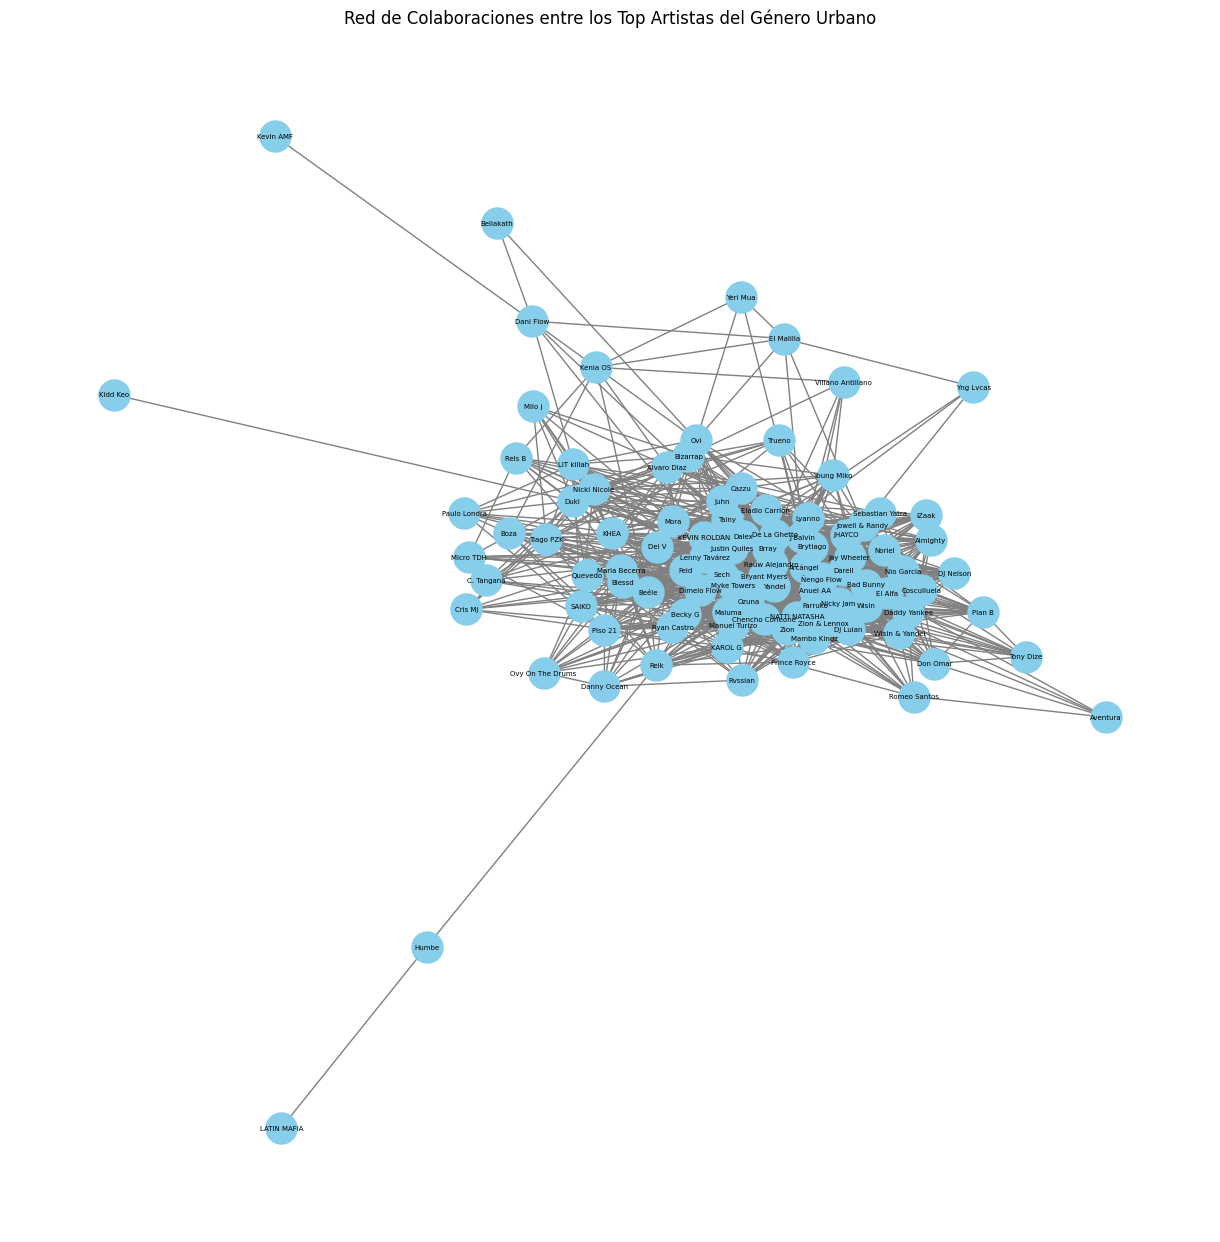

In [591]:
# Construir el grafo
G = nx.Graph()
for index, row in tracks_df.iterrows():
    G.add_edge(row['artist_name'], row['collaborator_name'], track=row['track_name'])

# Visualizar el grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=5, edge_color='gray')
plt.title('Red de Colaboraciones entre los Top Artistas del Género Urbano')
plt.show()

In [592]:
# Calcular el grado de los nodos
node_degrees = dict(G.degree())

# Filtrar los nodos más activos (por ejemplo, los top 10 con mayor grado)
top_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:55]

# Crear un subgrafo con los nodos más activos
G = G.subgraph(top_nodes).copy()


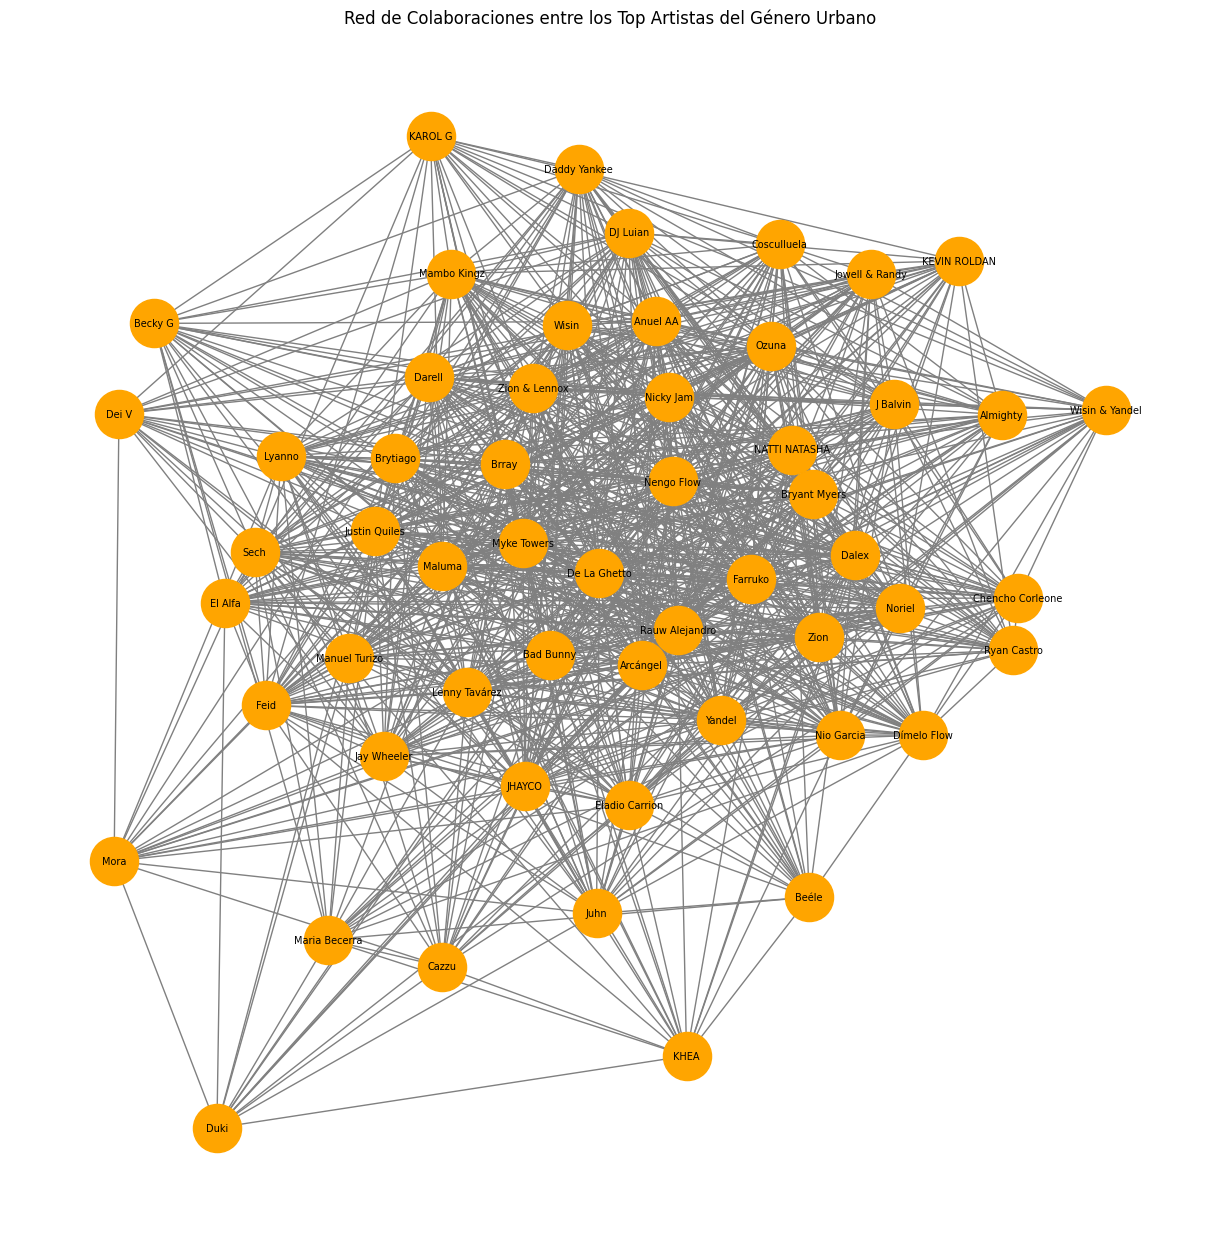

In [593]:
# Visualizar el grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1200, node_color='orange', font_size=7, edge_color='gray')
plt.title('Red de Colaboraciones entre los Top Artistas del Género Urbano')
plt.show()

Esta red te permite visualizar cómo están relacionados los géneros musicales en función de los artistas que escuchas en tus listas de reproducción. Es una forma interesante de ver las intersecciones entre diferentes géneros y cómo tu preferencia musical se extiende a través de estos géneros.

Este código garantiza que el grafo G contiene solo la mayor componente conexa, eliminando los nodos periféricos, y procede con el análisis y la visualización de esta red centralizada.

## Análisis Básicos
### 1. Número de Nodos y Aristas

In [594]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Número de géneros (nodos): {num_nodes}")
print(f"Número de conexiones (aristas): {num_edges}")

Número de géneros (nodos): 55
Número de conexiones (aristas): 957


In [595]:
# Análisis Adicional - Características Básicas de la Red
density = nx.density(G)
print(f"Densidad de la Red: {density}")

Densidad de la Red: 0.6444444444444445


### 2. Grado de los Nodos

In [623]:
degrees = dict(G.degree())
sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

# Top 10 artistas con mayor grado
top_10 = sorted_degrees[:10]
print("\nTop 10 artistas con mayor grado:")
for genre, degree in top_10:
    print(f"{genre}: {degree}")


Top 10 artistas con mayor grado:
De La Ghetto: 50
Rauw Alejandro: 49
Myke Towers: 48
Arcángel: 48
Anuel AA: 46
Justin Quiles: 46
Farruko: 45
Bad Bunny: 43
Ozuna: 42
Nicky Jam: 42


### 3. Distribución de Grados

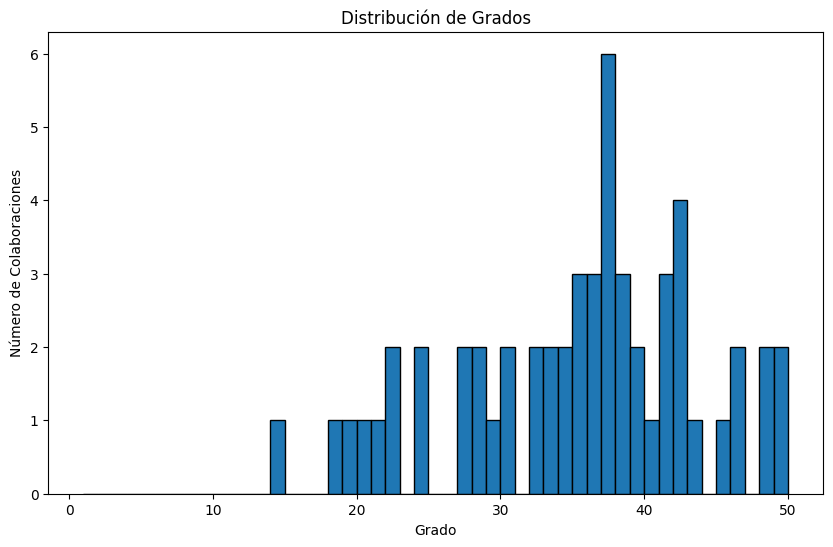

In [613]:
plt.figure(figsize=(10, 6))
plt.hist(list(degrees.values()), bins=range(1, max(degrees.values()) + 1), edgecolor='black')
plt.title("Distribución de Grados")
plt.xlabel("Grado")
plt.ylabel("Número de Colaboraciones")
plt.show()

### 4. Componentes Conexas

In [598]:
connected_components = list(nx.connected_components(G))
num_components = len(connected_components)
print(f"Número de componentes conexas: {num_components}")
print("Componentes conexas:")
for i, component in enumerate(connected_components):
    print(f"Componente {i + 1}: {component}")

Número de componentes conexas: 1
Componentes conexas:
Componente 1: {'J Balvin', 'Cazzu', 'De La Ghetto', 'Myke Towers', 'Nicky Jam', 'DJ Luian', 'Maluma', 'Brray', 'Rauw Alejandro', 'Dei V', 'Arcángel', 'Almighty', 'Dímelo Flow', 'Juhn', 'Zion', 'Duki', 'KEVIN ROLDAN', 'Mambo Kingz', 'Farruko', 'Bad Bunny', 'Wisin', 'Darell', 'NATTI NATASHA', 'Ryan Castro', 'Jay Wheeler', 'Ñengo Flow', 'Feid', 'Wisin & Yandel', 'Sech', 'Daddy Yankee', 'Mora', 'El Alfa', 'Lyanno', 'Bryant Myers', 'Manuel Turizo', 'Becky G', 'Yandel', 'JHAYCO', 'Cosculluela', 'Lenny Tavárez', 'Chencho Corleone', 'KAROL G', 'Zion & Lennox', 'Brytiago', 'Maria Becerra', 'Nio Garcia', 'Eladio Carrion', 'Ozuna', 'KHEA', 'Jowell & Randy', 'Justin Quiles', 'Dalex', 'Noriel', 'Anuel AA', 'Beéle'}


In [599]:
largest_cc = max(nx.connected_components(G), key=len)
print(f"Tamaño de la mayor componente conexa: {len(largest_cc)}")

Tamaño de la mayor componente conexa: 55


## Análisis Adicional
### Centralidad de Grado

In [614]:
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
print("\nTop 10 artistas por centralidad de grado:")
for genre, centrality in sorted_degree_centrality[:10]:
    print(f"{genre}: {centrality}")


Top 10 artistas por centralidad de grado:
De La Ghetto: 0.9259259259259258
Rauw Alejandro: 0.9074074074074073
Myke Towers: 0.8888888888888888
Arcángel: 0.8888888888888888
Anuel AA: 0.8518518518518519
Justin Quiles: 0.8518518518518519
Farruko: 0.8333333333333333
Bad Bunny: 0.7962962962962963
Ozuna: 0.7777777777777777
Nicky Jam: 0.7777777777777777


### Centralidad de Cercanía

In [615]:
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)
print("\nTop 10 Artistas por centralidad de cercanía:")
for genre, centrality in sorted_closeness_centrality[:10]:
    print(f"{genre}: {centrality}")


Top 10 Artistas por centralidad de cercanía:
De La Ghetto: 0.9310344827586207
Rauw Alejandro: 0.9152542372881356
Myke Towers: 0.9
Arcángel: 0.9
Anuel AA: 0.8709677419354839
Justin Quiles: 0.8709677419354839
Farruko: 0.8571428571428571
Bad Bunny: 0.8307692307692308
Ozuna: 0.8181818181818182
Nicky Jam: 0.8181818181818182


### Centralidad de Intermediación

In [616]:
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
print("\nTop 10 artistas por centralidad de intermediación:")
for genre, centrality in sorted_betweenness_centrality[:10]:
    print(f"{genre}: {centrality}")


Top 10 artistas por centralidad de intermediación:
De La Ghetto: 0.017363239841902044
Rauw Alejandro: 0.016401647118968396
Arcángel: 0.014641043237416178
Justin Quiles: 0.014627253121777777
Myke Towers: 0.014180195466090124
Bad Bunny: 0.013432002386272348
Lenny Tavárez: 0.010915540981887767
Sech: 0.010268348717434948
Farruko: 0.01006662719266602
Anuel AA: 0.009707556378021209


### Coeficiente de Agrupamiento

In [617]:
# Coeficiente de Agrupamiento
clustering_coefficient = nx.clustering(G)
sorted_clustering_coefficient = sorted(clustering_coefficient.items(), key=lambda item: item[1], reverse=True)
print("\nTop 10 artistas por coeficiente de agrupamiento:")
for genre, coefficient in sorted_clustering_coefficient[:10]:
    print(f"{genre}: {coefficient}")


Top 10 artistas por coeficiente de agrupamiento:
Almighty: 0.8490028490028491
Wisin & Yandel: 0.8233618233618234
Daddy Yankee: 0.8064516129032258
Jowell & Randy: 0.7881773399014779
Cosculluela: 0.7865546218487395
KEVIN ROLDAN: 0.7857142857142857
El Alfa: 0.7816091954022989
Beéle: 0.7748917748917749
Bryant Myers: 0.7717717717717718
Ryan Castro: 0.7698412698412699


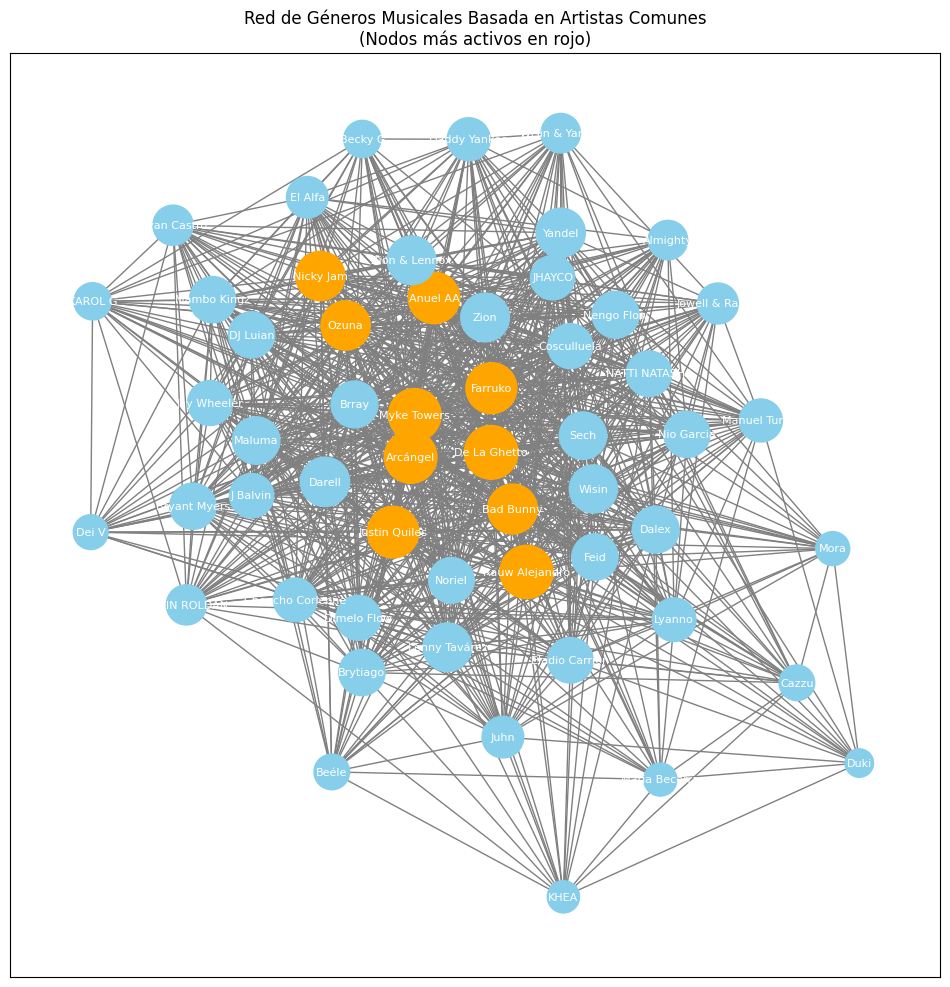

In [621]:
# Dibujar el grafo
plt.figure(figsize=(12, 12))

# Colores de los nodos según su grado (número de conexiones)
node_colors = ['orange' if genre in dict(top_10) else 'skyblue' for genre in G.nodes()]

# Tamaños de los nodos según su grado (número de conexiones)
node_sizes = [degrees[genre] * 30 for genre in G.nodes()]

# Dibujar los nodos y las aristas
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='white')

plt.title('Red de Géneros Musicales Basada en Artistas Comunes\n(Nodos más activos en rojo)')
plt.show()

## Análisis de Predicción de Enlaces
Utilizaremos algunas de las métricas comunes para la predicción de enlaces, como:

In [605]:
# Obtener los pares de nodos no adyacentes
non_adjacent = non_adjacent_pairs(G)

# Calcular Common Neighbors
common_neighbors = [(u, v, len(list(nx.common_neighbors(G, u, v)))) for u, v in non_adjacent]

# Calcular Jaccard Coefficient
jaccard_coefficient = list(nx.jaccard_coefficient(G, non_adjacent))

# Calcular Resource Allocation Index
resource_allocation_index = list(nx.resource_allocation_index(G, non_adjacent))

# Calcular Preferential Attachment
preferential_attachment = list(nx.preferential_attachment(G, non_adjacent))

### Common Neighbors:
Dos nodos tienen una mayor probabilidad de formar un enlace si comparten muchos vecinos comunes.

In [606]:
print("Top 10 predicciones de enlaces más probables basadas en Common Neighbors:")
for u, v, p in top_n_predictions(common_neighbors):
    print(f"{u} - {v}: {p}")

Top 10 predicciones de enlaces más probables basadas en Common Neighbors:
Ozuna - Justin Quiles: 39
Justin Quiles - Ozuna: 39
NATTI NATASHA - De La Ghetto: 34
De La Ghetto - NATTI NATASHA: 34
Justin Quiles - Nio Garcia: 33
Nio Garcia - Justin Quiles: 33
Anuel AA - Feid: 32
J Balvin - Myke Towers: 32
Ozuna - Lenny Tavárez: 32
Myke Towers - J Balvin: 32


### Jaccard Coefficient: 
Mide la similitud entre dos nodos basada en sus vecinos.

In [607]:
print("\nTop 10 predicciones de enlaces más probables basadas en Jaccard Coefficient:")
for u, v, p in top_n_predictions(jaccard_coefficient):
    print(f"{u} - {v}: {p}")


Top 10 predicciones de enlaces más probables basadas en Jaccard Coefficient:
Ozuna - Justin Quiles: 0.7959183673469388
Justin Quiles - Ozuna: 0.7959183673469388
Wisin - Ñengo Flow: 0.6956521739130435
Ñengo Flow - Wisin: 0.6956521739130435
Bryant Myers - Yandel: 0.6808510638297872
Yandel - Bryant Myers: 0.6808510638297872
Justin Quiles - Nio Garcia: 0.66
Nio Garcia - Justin Quiles: 0.66
Zion & Lennox - Brytiago: 0.6595744680851063
Brytiago - Zion & Lennox: 0.6595744680851063


### Resource Allocation Index: 
Asigna puntuaciones a pares de nodos basadas en la cantidad de recursos compartidos por sus vecinos comunes.

In [608]:

print("\nTop 10 predicciones de enlaces más probables basadas en Resource Allocation Index:")
for u, v, p in top_n_predictions(resource_allocation_index):
    print(f"{u} - {v}: {p}")



Top 10 predicciones de enlaces más probables basadas en Resource Allocation Index:
Ozuna - Justin Quiles: 1.0993007941176096
Justin Quiles - Ozuna: 1.0993007941176096
NATTI NATASHA - De La Ghetto: 0.940309873902488
De La Ghetto - NATTI NATASHA: 0.940309873902488
Bad Bunny - Brray: 0.9030995104500962
Brray - Bad Bunny: 0.9030995104500962
Ozuna - Lenny Tavárez: 0.8817027083257194
Lenny Tavárez - Ozuna: 0.8817027083257194
Anuel AA - Feid: 0.8773364298233352
Feid - Anuel AA: 0.8773364298233352


### Preferential Attachment: 
La probabilidad de que dos nodos se conecten es proporcional al producto de sus grados.

In [609]:
print("\nTop 10 predicciones de enlaces más probables basadas en Preferential Attachment:")
for u, v, p in top_n_predictions(preferential_attachment):
    print(f"{u} - {v}: {p}")


Top 10 predicciones de enlaces más probables basadas en Preferential Attachment:
Ozuna - Justin Quiles: 1932
Justin Quiles - Ozuna: 1932
NATTI NATASHA - De La Ghetto: 1800
De La Ghetto - NATTI NATASHA: 1800
Bad Bunny - Lenny Tavárez: 1763
Lenny Tavárez - Bad Bunny: 1763
Ozuna - Lenny Tavárez: 1722
Lenny Tavárez - Ozuna: 1722
Anuel AA - Feid: 1702
Feid - Anuel AA: 1702
